In [66]:
import pandas as pd
import numpy as np
import re
import plotly.plotly as plt
import plotly.graph_objs as go
import plotly
import plotly.figure_factory as ff
plotly.tools.set_credentials_file(username='mail929', api_key='ir0fPXDlHcfJLXLmsP99')
%matplotlib inline

In [11]:
def getNumbers(date):
    nums = []
    last = -2
    for i,c in enumerate(date):
        if c.isdigit():
            if last == i-1:
                nums[-1] += c
            else:
                nums.append(c)
            last = i
    try:
        r = [int(n) for n in nums]
        return r
    except:
        return []

def getDate(date):
    date = date.split('(')[0].split('[')[0].split(',')[0].split('or')[0].split(';')[0].split('and')[0]
    nums = getNumbers(date)
    if len(nums) == 0 or date.find('B.C') > -1 or date.find('BC') > -1 or any(x > 2018 for x in nums):
        return None
    elif date.find('century') > -1:
        if date.find('early') > -1:
            end = '25'
        elif date.find('late') > -1:
            end = '75'
        else:
            end = '50'
        if len(nums) > 1:
            if(nums[1] > 21):
                return nums[1]
            elif(nums[0] > 21):
                return nums[0]
            else:
                end = '00'
                century = int(np.mean(nums))
        else:
            century = nums[0]
        return int(str(century - 1) + end)
    elif len(nums) > 1:
        if nums[1] > 100:
            return int(np.mean(nums))
        else:
            c = int(nums[0] / 100)
            return int((np.mean([nums[0], c + nums[1]])))
    elif len(nums) == 1:
        return int(nums[0])
    return None

def getCentury(year):
    if np.isnan(year):
        return None
    else:
        return int(year/100)+1
    
def getDonor(creditLine):
    parts = creditLine.split(',')
    nums = getNumbers(parts[-1])
    if len(nums) > 0:
        return creditLine[0:creditLine.rfind(',')]       
    else:
        return creditLine
    
def getDonorYear(creditLine):
    parts = creditLine.split(',')
    nums = getNumbers(parts[-1])
    if len(nums) > 0 and nums[0] <= 2018 and nums[0] >= 1870:
        return nums[0]
    else:
        return None

In [12]:
def getDate2(date):
    date = date.lower()
    if date.find('b.c') > -1 or date.find('bc') > -1:
        return None
    
    years = re.findall(r'(?<!\d)\d{3,4}(?!\d)', date)
    if len(years) == 1:
        yRange = re.findall(r'(?<!\d)\d{3,4}–\d{2}(?!\d)', date)
        if len(yRange) > 0:
            parts = yRange[0].split('–')
            start = int(parts[0])
            return int(np.mean([start, int(start/100)*100 + int(parts[1])]))
        return int(years[0])
    elif len(years) == 2:
        return int(np.mean([int(y) for y in years]))
    elif date.find('century') > -1:
        centuries = re.findall(r'(?<!\d)\d{2}(?=th century)', date)
        if len(centuries) > 0:
            start = re.findall(r'(?<!\d)\d{2}(?=th–)', date)
            if len(start) == 0:
                year = int(centuries[0])
                if date.find('early') > -1:
                    year += 0.25
                elif date.find('late') > -1:
                    year += 0.75
                elif date.find('second') > -1:
                    year += 0.75
                elif date.find('first') > -1:
                    year += 0.25
                else:
                    year += 0.5
            else:
                year = np.mean([int(centuries[0]), int(start[0])])
            return int((year - 1)*100)
    return None

In [13]:
raw = pd.read_csv('MetObjects.csv', index_col='Object Number', dtype=str)

In [14]:
# Collect columns we need and process into a cleaner table
pd.options.mode.chained_assignment = None
titledate = raw[['Title', 'Object Date', 'Artist Display Name', 'Credit Line', 'Link Resource']]
titledate['Year'] = titledate['Object Date'].apply(lambda x: getDate2(str(x)))
titledate = titledate.loc[titledate['Year'] <= 2018]
titledate['Century'] = titledate['Year'].apply(lambda x: getCentury(x))
titledate['Credit Line'] = titledate['Credit Line'].astype(str)
titledate['Donor'] = titledate['Credit Line'].apply(lambda x: getDonor(x))
titledate['Donation Year'] = titledate['Credit Line'].apply(lambda x: getDonorYear(x))

In [15]:
# Attempt to sort out Christian artworks
cStrings = ['christ ', 'heaven', 'the lord ', 'crucifixion', 'good shepherd', 'satan', 'saint', 'christianity', 'catholic', 'angel ', 'ascension', 'lamentation', 'epiphany', 'madonna', 'resurrection', 'mother mary', 'the cross', 'apostle']
comparison = '|'.join(cStrings)
cArt = titledate.loc[titledate['Title'].str.contains(comparison, na=False, case=False)]

# Save to file for manual processing
#cArt.to_csv('christian-art.csv')

cArt.head()

,Title,Object Date,Artist Display Name,Credit Line,Link Resource,Year,Century,Donor,Donation Year
Object Number,,,,,,,,,
53.77,Christ and the Two Lepers,1903–31,Wright Goodhue,"Gift of Mrs. Mary Louise Goodhue, 1953",http://www.metmuseum.org/art/collection/search...,1917.0,20,Gift of Mrs. Mary Louise Goodhue,1953.0
34.100.75,Drawing of the Crucifixion,1800,NaN,"Gift of Mrs. Robert W. de Forest, 1933",http://www.metmuseum.org/art/collection/search...,1800.0,19,Gift of Mrs. Robert W. de Forest,1933.0
34.100.82,Drawing of the Crucifixion,ca. 1800,NaN,"Gift of Mrs. Robert W. de Forest, 1933",http://www.metmuseum.org/art/collection/search...,1800.0,19,Gift of Mrs. Robert W. de Forest,1933.0
56.53,A Study from Life [and] Study for Angel Releas...,ca. 1815,Washington Allston,"Gift of the Allston Trust, 1956",http://www.metmuseum.org/art/collection/search...,1815.0,19,Gift of the Allston Trust,1956.0
60.44.16,"Study for ""The Ascension""",1774,John Singleton Copley,"Harris Brisbane Dick Fund, 1960",http://www.metmuseum.org/art/collection/search...,1774.0,18,Harris Brisbane Dick Fund,1960.0


In [16]:
# Count amount of Christian artworks in each century
centuries = cArt['Century'].value_counts()
centuries = centuries.sort_index()
#centuries

In [17]:
# Count amount of all atrworks in each century A.D.
acenturies = titledate['Century'].value_counts()
acenturies = acenturies.sort_index()
#acenturies

In [18]:
# Calculate the percentage of christian art to all art in each century
percent = centuries * 100 / acenturies
percent = percent.fillna(0)
#percent

Text(0.5,0,'Century')

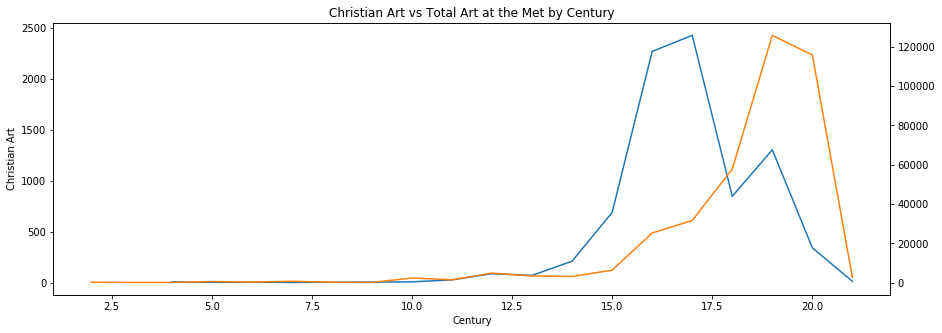

In [19]:
# Plot each count of art per century
cAxis = centuries.plot(kind = 'line', figsize = (15,5), title='Christian Art vs Total Art at the Met by Century')
aAxis = acenturies.plot(kind = 'line', secondary_y=True)
cAxis.set_ylabel('Christian Art')
cAxis.set_xlabel('Century')
#cAxis.set_ylabel('All Art')

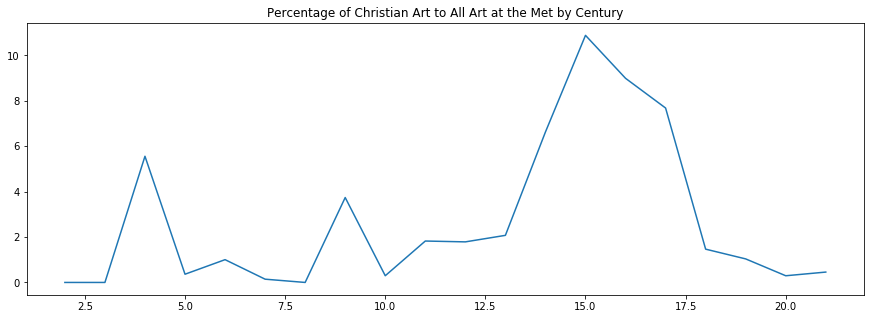

In [20]:
# Plot percentage of christian art to all art
pAxis = percent.plot(kind = 'line', title='Percentage of Christian Art to All Art at the Met by Century', figsize = (15,5))

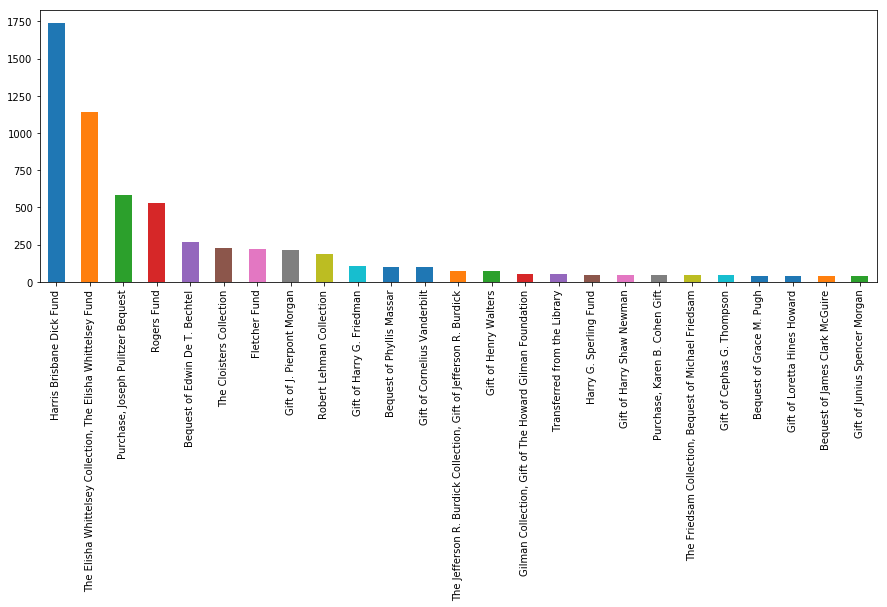

In [42]:
# Count christian art donors
donations = cArt['Donor'].value_counts()
donations[:25].plot(kind='Bar', figsize = (15,5))

In [22]:
# Attempt to find all instances of Madonna and Child
mc = titledate.loc[titledate['Title'].str.contains('virgin|madonna', na=False, case=False) & titledate['Title'].str.contains('child|christ', na=False, case=False)]
#mc

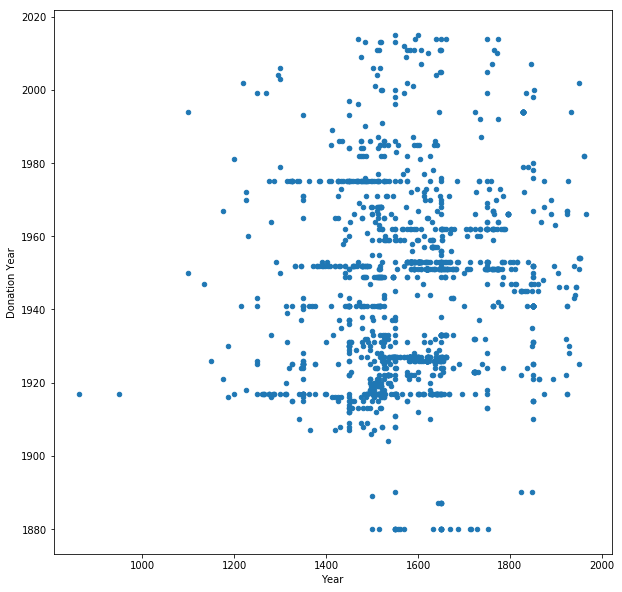

In [51]:
# Plot donation year against creation year for madonna and child
mc.plot(kind='scatter', x='Year', y='Donation Year', figsize = (10,10))

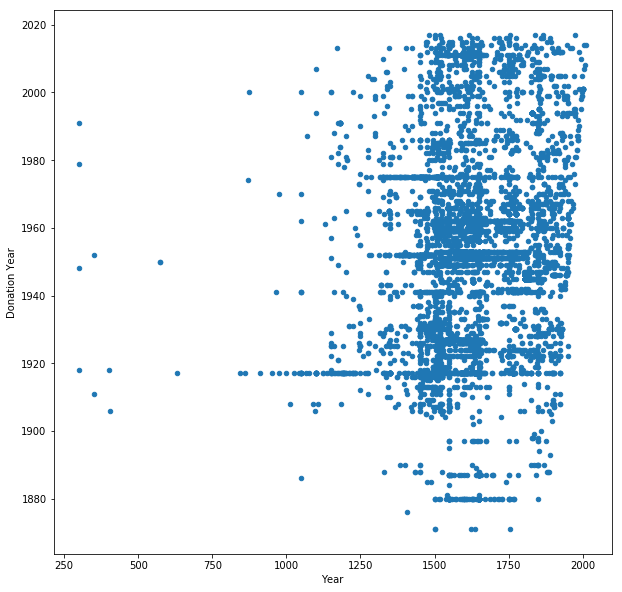

In [52]:
# For all christian art
cArt.plot(kind='scatter', x='Year', y='Donation Year', figsize = (10,10))

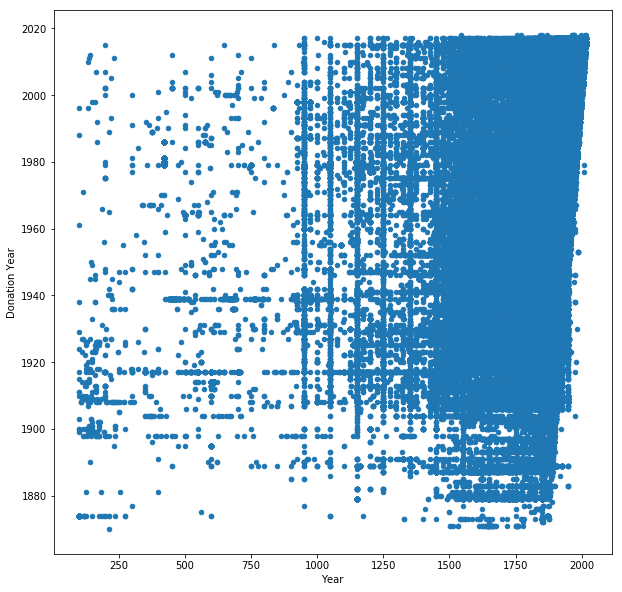

In [71]:
# For all art
titledate.plot(kind='scatter', x='Year', y='Donation Year', figsize = (10,10))

In [70]:
fig = ff.create_2d_density(
    mc['Century'], mc['Donation Year']
)

plt.iplot(fig, filename='histogram_subplots')

In [69]:
fig = ff.create_2d_density(
    cArt['Century'], cArt['Donation Year']
)

plt.iplot(fig, filename='histogram_subplots')